# Image classification with CNNs
[![Open in Layer](https://development.layer.co/assets/badge.svg)](https://development.layer.co/layer/derrick-cnn) [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/layerai/examples/blob/main/image-classification/image_classification_with_CNNs.ipynb) [![Layer Examples Github](https://badgen.net/badge/icon/github?icon=github&label)](https://github.com/layerai/examples/tree/main/image-classification)

In this notebook we look at how to train a CNN from scratch using the cats and dogs dataset.

In [1]:
!pip install --upgrade layer-sdk -qqq

     |████████████████████████████████| 29.5 MB 54 kB/s 
     |████████████████████████████████| 596 kB 18.2 MB/s 
     |████████████████████████████████| 132 kB 36.1 MB/s 
     |████████████████████████████████| 4.0 MB 31.6 MB/s 
     |████████████████████████████████| 96 kB 3.5 MB/s 
     |████████████████████████████████| 16.5 MB 90 kB/s 
     |████████████████████████████████| 159 kB 33.1 MB/s 
     |████████████████████████████████| 26.7 MB 2.5 MB/s 
     |████████████████████████████████| 56 kB 2.8 MB/s 
     |████████████████████████████████| 381 kB 27.8 MB/s 
     |████████████████████████████████| 256 kB 34.3 MB/s 
     |████████████████████████████████| 97 kB 2.6 MB/s 
     |████████████████████████████████| 40 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 13.6 MB/s 
     |████████████████████████████████| 3.6 MB 33.4 MB/s 
     |████████████████████████████████| 2.4 MB 41.5 MB/s 
     |████████████████████████████████| 212.4 MB 65 kB/s 
     |██████████████████

In [2]:
import layer

In [ ]:
layer.login()

In [4]:
from layer.decorators import model, pip_requirements, fabric

In [5]:
layer.init("derrick-cnn")

Project(name='derrick-cnn', raw_datasets=[], derived_datasets=[], featuresets=[], models=[], path=PosixPath('.'), project_files_hash='', readme='', organization=Organization(id=UUID('d7325da3-0646-4fa6-855d-8d19eece8b79'), name='layer'), _id=UUID('54de9921-fdc4-414a-89ca-8ce39094fe8f'), functions=[])

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=165a26acdf10ac2913e55b38771a6ecc5f85f017d891b9b227b2268e1086c9a4
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
@pip_requirements(packages=["wget","tensorflow","keras"])
@fabric("f-medium")
@model("cnn")
def train():
  import tensorflow as tf
  import wget
  from tensorflow import keras
  from tensorflow.keras import Sequential
  from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras.callbacks import EarlyStopping
  import os
  import matplotlib.pyplot as plt 
  import pandas as pd
  import zipfile
  wget.download("https://namespace.co.ke/ml/train.zip")
  with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')
  base_dir = 'train/train'
  filenames = os.listdir(base_dir)
  categories = []
  for filename in filenames:
      category = filename.split('.')[0]
      if category == 'dog':
          categories.append("dog")
      else:
          categories.append("cat")

  df = pd.DataFrame({'filename': filenames,'category': categories})
  train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   validation_split=0.2
                                   )
  validation_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
  image_size = (200, 200)
  training_set = train_datagen.flow_from_dataframe(df,base_dir,
                                                 seed=101,                                                 
                                                 target_size=image_size,
                                                 batch_size=32,
                                                 x_col='filename',
                                                 y_col='category',
                                                 subset = "training",
                                                 class_mode='binary')
  validation_set = validation_gen.flow_from_dataframe(df,base_dir, 
                                               target_size=image_size,
                                               batch_size=32, 
                                               x_col='filename',
                                                 y_col='category',
                                               subset = "validation",
                                               class_mode='binary')
  model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),  input_shape = (200, 200, 3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')])
  model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])
  callback = EarlyStopping(monitor='loss', patience=3)
  epochs=1
  history = model.fit(training_set,validation_data=validation_set, epochs=epochs,callbacks=[callback])
  metrics_df = pd.DataFrame(history.history)
  layer.log({"metrics DataFrame": metrics_df})
  loss, accuracy = model.evaluate(validation_set)
  print('Accuracy on test dataset:', accuracy)
  metrics_df[["loss","val_loss"]].plot()
  layer.log({"Loss plot": plt.gcf()})
  metrics_df[["binary_accuracy","val_binary_accuracy"]].plot()
  layer.log({"Accuracy plot": plt.gcf()})
  return model

In [ ]:
# Run the project on Layer Infra
layer.run([train])

Output()

Run(project_name='derrick-cnn')

In [6]:
import numpy as np
from keras.preprocessing import image

In [7]:
model = layer.get_model('layer/derrick-cnn/models/cnn').get_train()

In [8]:
!wget --no-check-certificate \
    https://upload.wikimedia.org/wikipedia/commons/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg \
    -O /tmp/cat.jpg

--2022-04-11 07:57:47--  https://upload.wikimedia.org/wikipedia/commons/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2114775 (2.0M) [image/jpeg]
Saving to: ‘/tmp/cat.jpg’

/tmp/cat.jpg        100%[===================>]   2.02M  11.2MB/s    in 0.2s    

2022-04-11 07:57:47 (11.2 MB/s) - ‘/tmp/cat.jpg’ saved [2114775/2114775]



In [13]:
test_image = image.load_img('/tmp/cat.jpg', target_size=(200, 200))
test_image_array = image.img_to_array(test_image)

In [10]:
test_image_array = np.expand_dims(test_image_array, axis=0)
prediction = model.predict(test_image_array)

The image is a cat


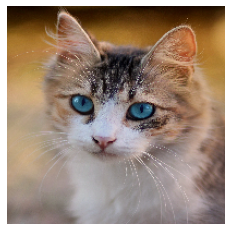

In [16]:
if prediction[0][0]>0.5:
  print(" is a dog")
else:
   print("The image is a cat")

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(test_image);